# Example usage of ease.ml/snoopy for feasibility study of ML applications

This example jupyter notebook illustrates how to use the ease.ml/snoopy library to perform an automatic feasibility study.

## Required imports

Let us start with defining the required imports in order to be able to define the target dataset and the set of pre-trained models (embeddings) used to perform the feasibility study

In [1]:
from collections import OrderedDict
from tensorflow_datasets import Split

from snoopy.embedding import EmbeddingConfig, uni_se
from snoopy.reader import TFDSTextConfig

[18:25:12] WARNING Snoopy may use all CPU cores! Set env. variable 'SNOOPY_LIMIT_CPU' to 'y' to limit CPU usage. (__init__ -> _init_tf_pytorch on MainThread)


## Configs
We next define the dataset (train and test splits) to fuse into the system

In [2]:
dataset_name = "imdb_reviews"
train_data_config = TFDSTextConfig(dataset_name=dataset_name, split=Split.TRAIN)
test_data_config = TFDSTextConfig(dataset_name=dataset_name, split=Split.TEST)
classes = 2

Then, we define a set of pre-trained models (embeddings) we want to use. Naturally, as we are taking the min over all possible transformations, the more models we specify here the better. Note nevertheless, that each additional model will require more compute time.

In [3]:
models = OrderedDict({
    "use": EmbeddingConfig(uni_se, batch_size=10, prefetch_size=1)
}) 

Finally, define a target error (1 - target accuracy)

In [4]:
target = 0.1

## Run Snoopy

### Addtional imports

In [5]:
import numpy as np
import os
import os.path as path
import torch as pt

from snoopy import set_cache_dir
from snoopy.pipeline import run, store_embeddings
from snoopy.result import BerStoringObserver
from snoopy.strategy import SimpleStrategyConfig
from snoopy.reader import ReaderConfig, data_factory

### Snoopy settings

In [6]:
set_cache_dir("cache")

results_folder = "results"
if not path.exists(results_folder):
    os.mkdir(results_folder)

### Run with Bayer Error Rate (BER) Storing Observer

In [7]:
test_data = data_factory(test_data_config)
test_size = float(test_data.size)

observer = BerStoringObserver(classes, test_size)

run(train_data_config=train_data_config,
    test_data_config=test_data_config,
    embedding_configs=models,
    strategy_config=SimpleStrategyConfig(train_size=1000, test_size=5_000),
    observer=observer,
    device=pt.device("cpu"))

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from cache/TFDS_cache/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (cache/TFDS_cache/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset imdb_reviews for split test, from cache/TFDS_cache/imdb_reviews/plain_text/1.0.0
[18:25:12] DEBUG   Loaded text dataset imdb_reviews (split: test) with 25000 points (tfds -> read_data on MainThread)
INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from cache/TFDS_cache/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (cache/TFDS_cache/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset imdb_reviews for split train, from cache/TFDS_cache/imdb_reviews/plain_text/1.0.0
[18:25:12] DEBUG   Loaded text dataset imdb_reviews (split: train) with 25000 points (tfds -> read_data on MainThread)
INFO:absl:No config specified, def

[18:25:56] DEBUG   Average feature retrieve time was  0.000 seconds (base -> _compute_embedding on MainThread)
[18:25:56] INFO    Current result: 
	use: PR(n=10000, err=6964) (result -> on_update on MainThread)
[18:25:57] DEBUG   Average feature retrieve time was  0.000 seconds (base -> _compute_embedding on MainThread)
[18:25:57] INFO    Current result: 
	use: PR(n=11000, err=6876) (result -> on_update on MainThread)
[18:25:58] DEBUG   Average feature retrieve time was  0.000 seconds (base -> _compute_embedding on MainThread)
[18:25:59] INFO    Current result: 
	use: PR(n=12000, err=6834) (result -> on_update on MainThread)
[18:26:00] DEBUG   Average feature retrieve time was  0.000 seconds (base -> _compute_embedding on MainThread)
[18:26:00] INFO    Current result: 
	use: PR(n=13000, err=6790) (result -> on_update on MainThread)
[18:26:01] DEBUG   Average feature retrieve time was  0.000 seconds (base -> _compute_embedding on MainThread)
[18:26:01] INFO    Current result: 
	use: PR(

### Store the results into the results folder

In [8]:
observer.store(results_folder)

[18:26:17] DEBUG   Storing embedding 'use' to file 'use' (result -> store on MainThread)


## Use the output of snoopy (BER estimate and plots)

As snoopy does output results in files, we next show how to use the results (BER estimate) and plots to guid users towards feasibility study.

In [9]:
# Set the random baseline as min achievable error first, then iterate over all models
min_error = (classes - 1.0) / float(classes)
for k in models.keys():
    f = path.join(results_folder, "{0}.npz".format(k))
    if path.exists(f):
        items = np.load(f)
        error = items['ber'][-1]
        min_error = min(min_error, error)

print('Minimal error achievable is {0:.4f}'.format(min_error))

Minimal error achievable is 0.1597


This means, that every target error above this value would be treated as _feasible_, and every target error below this value as _infeasible_.

In [10]:
print('Target Achievable: ', target > min_error)

Target Achievable:  False


To trust, or ignore the signal of snoopy, one typically also inspects the convergence plots:

[None, None]

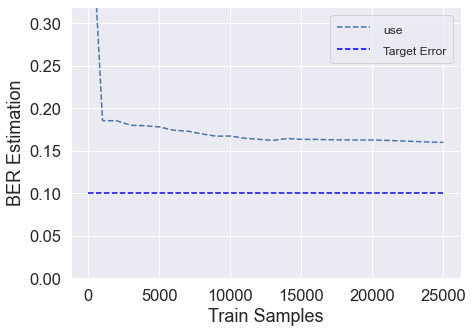

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font="lato")
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

min_tn = (classes - 1.0) / float(classes)
train_size = 0
f = plt.figure(figsize=(7, 5))
for idx, k in enumerate(models.keys()):
    f = path.join(results_folder, "{0}.npz".format(k))
    if not path.exists(f):
        continue
        
    items = np.load(f)

    ax = sns.lineplot(x=items['n'], y=items['ber'])

    min_tn = min(min_tn, min(items['ber']))
    train_size = max(train_size, max(items['n']))

    ax.lines[-1].set_linestyle("--")
    ax.lines[-1].set_label("{}".format(k))

if target is not None:
  x = [0, train_size]
  sns.lineplot(x=x, y=[target]*len(x), ax=ax)
  ax.lines[-1].set_color("Blue")
  ax.lines[-1].set_linestyle("--")
  ax.lines[-1].set_label("Target Error")

ax.legend()

ax.set_ylim(0.0, min(1.0, max(target, min_tn)*2.0))
ax.set_ylabel("BER Estimation")
ax.set_xlabel("Train Samples")

plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title

## Explanations

The plot above could indicate that it is very likely that even with many more samples, the curve using ```use``` as an embedding will still not converge below the target error and hence remains infeasible. If the best embedding did not converge though, one would want to gather more data to have a decisive answer. Alternatively, if a curve converged above a target accuracy (like in our case), the negative answer could still be off (i.e., false negative). This happens if the transformation bias increased the BER significantly (e.g., because it was trained on a too different soruce distributtion).
False positive also can occure, although rarely seen in practice. The estimated bounds are lower bounds on the _true_ BER. It is known that these bounds are not tight always, therefore resulting in an overly optimistic answer.